In [1]:
import sys 
import os

sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'modules'))

import pandas as pd

In [2]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)



In [3]:
results=pd.DataFrame()
for file in os.listdir('metrics'):
    #print(file)
    _r = pd.read_csv(f"metrics/{file}",header=[0,1,2],index_col=[0],parse_dates=True)
    results = pd.concat([results,_r],axis=0)

In [5]:
#results

In [6]:
sort_col = ('2009-08-04 00:00:00', 'valid', 'accuracy_score')
results.sort_values(by=[sort_col],ascending=False).head(25).style.apply(highlight_max)

In [7]:
import sys 
import os
import yaml
#sys.path.append(os.path.abspath("/home/energycorp.com/srv_ipython_mce/jupyterhub/homes/u51797/ml_pgm/fitmodels/"))

from plots import plots_1mw
from fit import extract_best_model, bin_datasets

c = yaml.load(open('msft.yaml','r'),Loader=yaml.FullLoader)

In [8]:
metric = 'accuracy_score'

In [9]:
bestmodel = pd.DataFrame(columns=['begin',metric,'model_fname'])

In [10]:
def extract_best_model(results,metric='accuracy_score',ds='valid'):
    bestmodel = pd.DataFrame(columns=['begin',metric,'model_fname'])
    for i,r in results.iterrows():
        _begin = None
        _metric = None
        for b in set(results.columns.get_level_values(0)):
            sort_col = (b, ds, metric)
            if _begin is None:
                _begin = b
                _metric = r[sort_col]
            else:
                if r[sort_col] > _metric:
                    _begin = b
                    _metric = r[sort_col]                
            bestmodel.loc[i,'begin'] = b
            bestmodel.loc[i,metric] = r[sort_col]
            bestmodel.loc[i,'begin'] = b
            bestmodel.loc[i,'model_fname'] = "models/{}_{}.dat".format(i,pd.Timestamp(b).strftime("%Y%m%d"))
    return bestmodel.reset_index().sort_values(by=metric,ascending=False)

In [11]:
#results = pd.read_csv("results.csv",header=[0,1,2],index_col=[0],parse_dates=True)
topresults = extract_best_model(results)
topresults.head(10)

,index,begin,accuracy_score,model_fname
35,SVC_C0.5_gammascale_kernelsigmoid_max_iter1000...,2009-08-04 00:00:00,0.601594,models/SVC_C0.5_gammascale_kernelsigmoid_max_i...
1,RandomForestClassifier_max_depth10_n_estimator...,2009-08-04 00:00:00,0.59761,models/RandomForestClassifier_max_depth10_n_es...
28,DecisionTreeClassifier_criteriongini_max_depth6,2009-08-04 00:00:00,0.589641,models/DecisionTreeClassifier_criteriongini_ma...
9,SVC_C1_gammascale_kernelsigmoid_max_iter1000_p...,2009-08-04 00:00:00,0.585657,models/SVC_C1_gammascale_kernelsigmoid_max_ite...
30,SVC_C1_gammascale_kernelrbf_max_iter1000_proba...,2009-08-04 00:00:00,0.581673,models/SVC_C1_gammascale_kernelrbf_max_iter100...
18,MLPClassifier_activationlogistic_alpha0.0001_h...,2009-08-04 00:00:00,0.577689,models/MLPClassifier_activationlogistic_alpha0...
37,LogisticRegression_l1_ratio0_penaltyelasticnet...,2009-08-04 00:00:00,0.573705,models/LogisticRegression_l1_ratio0_penaltyela...
32,MLPClassifier_activationlogistic_alpha0.0001_h...,2009-08-04 00:00:00,0.573705,models/MLPClassifier_activationlogistic_alpha0...
16,RandomForestClassifier_max_depth8_n_estimators500,2009-08-04 00:00:00,0.573705,models/RandomForestClassifier_max_depth8_n_est...
15,SVC_C1_gammascale_kernellinear_max_iter1000_pr...,2009-08-04 00:00:00,0.573705,models/SVC_C1_gammascale_kernellinear_max_iter...


In [12]:
import joblib


file = c['dpath']+c['dvarsel']
data = pd.read_parquet(file)

bfile = c['dpath']+c['dbins']
bins = joblib.load(bfile)

tgt = c['target']

binned_feat = list(bins.keys())
binned_feat.sort()
woe_feat = [x+'_woe' for x in binned_feat]
#results = pd.read_csv("results.csv",header=[0,1,2],index_col=[0],parse_dates=True)
topresults = extract_best_model(results)
topresults
lst = list(zip(topresults['index'],topresults['model_fname']))

In [13]:
#data.columns

y_train,y_valid,y_test,X_train,X_valid,X_test,dataset,valiset,testset = \
    bin_datasets(data,bins,tgt,
    begin_training  = pd.Timestamp(c['begin_training']),
    end_training    = pd.Timestamp(c['end_training']),
    begin_valid     = pd.Timestamp(c['begin_valid']),
    end_valid       = pd.Timestamp(c['end_valid']),
    begin_test      = pd.Timestamp(c['begin_test']),
    end_test        = pd.Timestamp(c['end_test']),
)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
2009-08-17 00:00:00 2017-12-29 00:00:00
2018-01-02 00:00:00 2018-12-31 00:00:00
2019-01-02 00:00:00 2019-08-16 00:00:00


In [14]:
import numpy as np

In [15]:
# Readd some dropped columns for plotting
_dataorig = pd.read_parquet(c['data'])
for var in [c['price_open'],c['price_close']]:
    dataset[var] = _dataorig[var]
    valiset[var] = _dataorig[var]
    testset[var] = _dataorig[var]

dataset['spread_sign'] = np.sign(_dataorig['spread'])
valiset['spread_sign'] = np.sign(_dataorig['spread'])
testset['spread_sign'] = np.sign(_dataorig['spread'])

dataset['target'] = _dataorig[tgt]
valiset['target'] = _dataorig[tgt]
testset['target'] = _dataorig[tgt]

cl_models = {
    x[0]: [joblib.load(x[1]),X_train[woe_feat],X_valid[woe_feat],X_test[woe_feat]] for x in lst[:4] if x[0][:3] != 'xgb'
}

# prob_models = {
#     'xgb':[model,dtrain,dvalidation,dtest]
# }
prob_models = {}

In [34]:
valiset

,target,OperatingIncomeLoss_woe,Open_woe,Close_woe,NetIncome_woe,spread_lag6_woe,spread_lag4_woe,PretaxIncomeLossAdj_woe,Days_Since_Report_woe,spread_lag8_woe,...,Dividend_woe,SharesOutstanding_woe,SellingGeneral&Administrative_woe,IncomeLossfromContinuingOperations_woe,SharesBasic_woe,spread_lag1_woe,dayofyear_woe,AdjClose,AdjClose_s1,spread_sign
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,True,0.159678,0.19667,0.281356,0.138372,-0.128521,-0.002243,0.153407,0.112814,-0.058247,...,0.194688,0.073777,-0.00518,0.138372,0.194656,-0.104433,-0.037283,82.79,83.18,1.0
2018-01-03,True,0.159678,0.19667,0.281356,0.138372,0.023823,-0.002243,0.153407,0.112814,0.138600,...,0.194688,0.073777,-0.00518,0.138372,0.194656,-0.104433,-0.037283,83.18,83.91,1.0
2018-01-04,True,0.159678,0.19667,0.281356,0.138372,-0.038522,-0.002243,0.153407,0.112814,-0.072288,...,0.194688,0.073777,-0.00518,0.138372,0.194656,-0.104433,-0.037283,83.91,84.95,1.0
2018-01-05,True,0.159678,0.19667,0.281356,0.138372,-0.128521,-0.002243,0.153407,0.112814,0.138600,...,0.194688,0.073777,-0.00518,0.138372,0.194656,-0.104433,-0.037283,84.95,85.04,1.0
2018-01-08,False,0.159678,0.19667,0.281356,0.138372,0.023823,-0.002243,0.153407,0.112814,-0.072288,...,0.194688,0.073777,-0.00518,0.138372,0.194656,-0.002007,-0.037283,85.04,84.98,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,True,0.205584,0.19667,0.148653,0.138372,0.273096,-0.089018,0.205584,-0.045533,-0.072288,...,0.194688,0.254234,0.17009,0.138372,0.194656,0.415228,-0.131130,92.25,98.55,1.0
2018-12-26,True,0.205584,0.19667,0.148653,0.138372,0.126370,0.047841,0.205584,-0.045533,0.350580,...,0.194688,0.254234,0.17009,0.138372,0.194656,-0.104433,-0.131130,98.55,99.15,1.0
2018-12-27,False,0.205584,0.19667,0.148653,0.138372,0.023823,0.047841,0.205584,-0.045533,0.350580,...,0.194688,0.254234,0.17009,0.138372,0.194656,-0.104433,-0.131130,99.15,98.38,-1.0


In [56]:
x0 = _dataorig.loc['2018-01-02','AdjClose']

In [57]:
x1 = _dataorig.loc['2018-12-31','AdjClose']

In [58]:
(x1 - x0) / x0

0.20231912066674718

In [59]:
65 / x0

0.7851189757217054

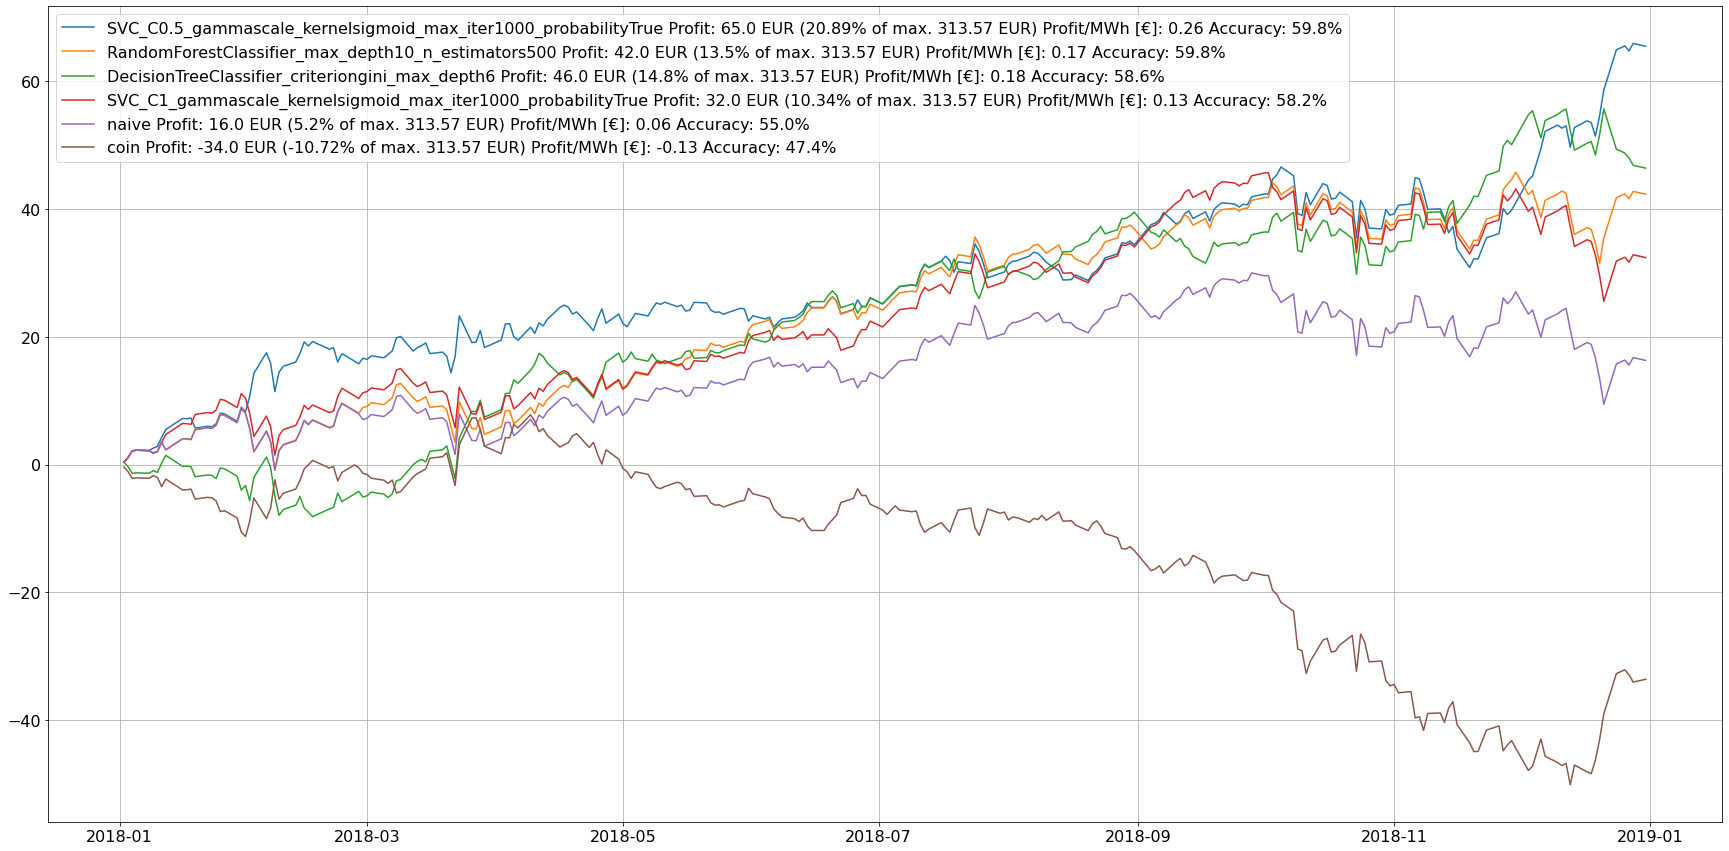

In [33]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots()
plt.grid()
plots_1mw(valiset, cl_models=cl_models,prob_models=prob_models,ax=ax,ix_dataset=2,descr_model=topresults.iloc[0,0] ,   price_open=c['price_open'],
    price_close=c['price_close'],)
#plt.savefig('test.png')

No handles with labels found to put in legend.


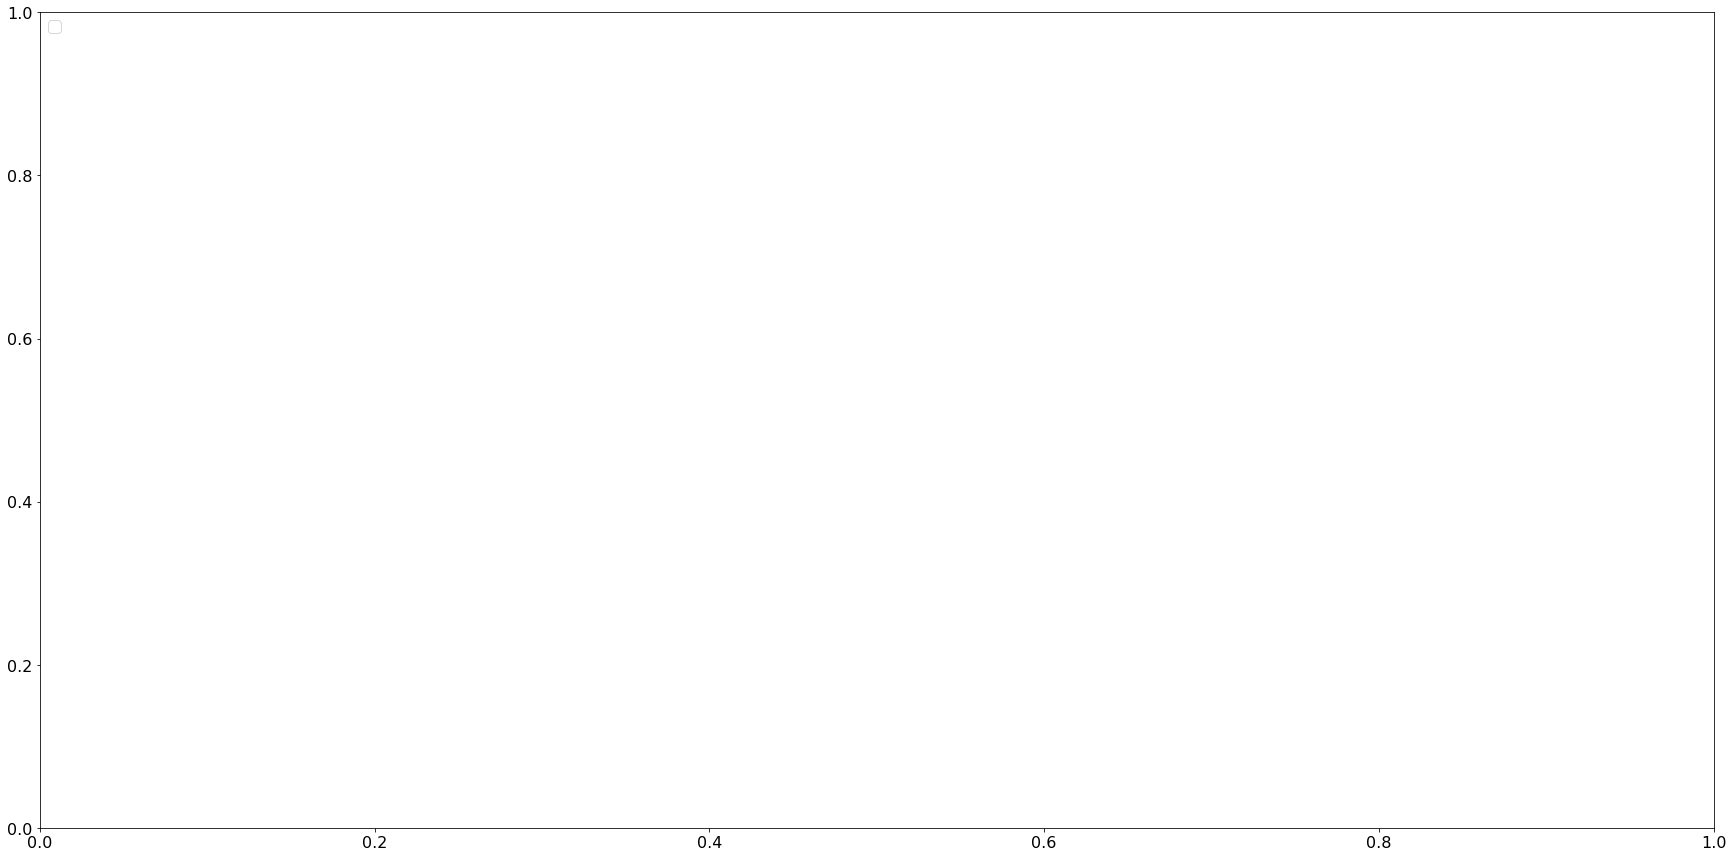

In [17]:
plots_1mw(testset, cl_models=cl_models,prob_models=prob_models,ax=ax,ix_dataset=3,descr_model=topresults.iloc[0,0] ,   price_open=c['price_open'],
    price_close=c['price_close'],)

In [ ]:
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve



In [19]:
key = topresults.iloc[0,0]
key

'SVC_C0.5_gammascale_kernelsigmoid_max_iter1000_probabilityTrue'

In [20]:
cl_models[key][0].predict_proba()

TypeError: _predict_proba() missing 1 required positional argument: 'X'

In [22]:
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve


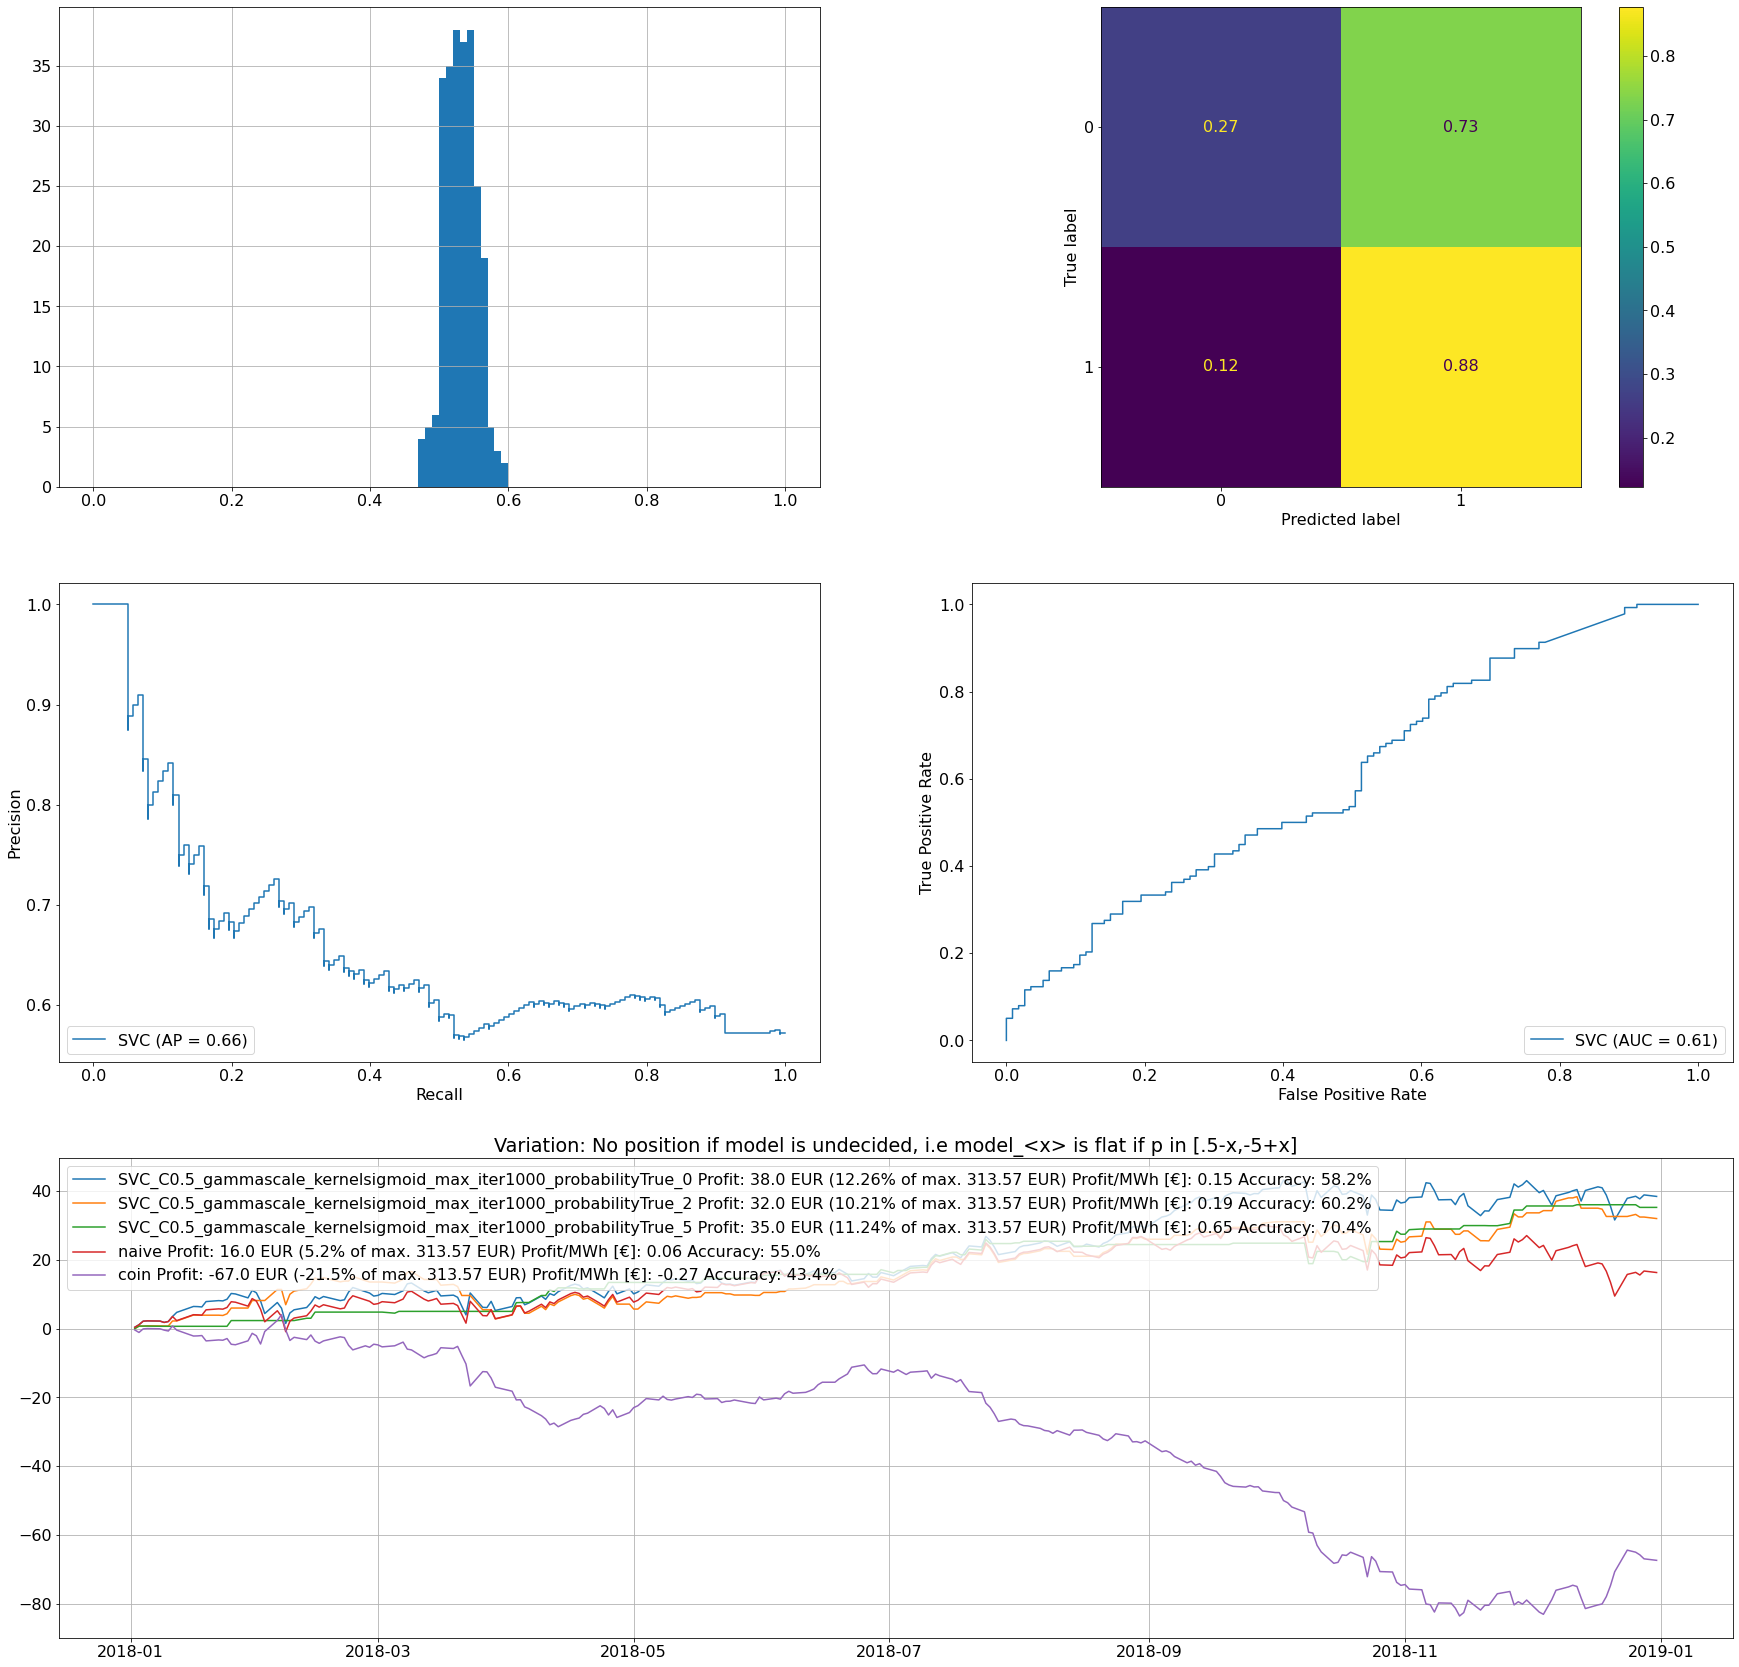

In [32]:
def plot_model_analysis(results, model=None,dpred=None,mname=None,axes=None,steps=None,price_open=c['price_open'],
    price_close=c['price_close'],naive_sign=1):
    
    results= results.drop(columns=results.filter(regex='xgb|naive|coin').columns)
    
    # Generic Benchmarks
    results['naive_sign'] = naive_sign
    results['coin_sign'] = np.random.choice([1,-1],results.shape[0])

    cutoff = 0.01
    for f in steps:
        m = mname+'_'+str(f)
        results[m+'_results'] =  model.predict_proba(dpred)[:,1]
        results[m+'_sign'] = 0
        results.loc[results[m+'_results'] <= 0.5-f*cutoff,m+'_sign'] = -1
        results.loc[results[m+'_results'] >= 0.5+f*cutoff,m+'_sign'] = 1
        results[m+"_profit"] = (results[price_close]-results[price_open])*(results[m+'_sign'])  
        results[m+"_profit_cum"] = results[m+"_profit"].cumsum()

    for var in ['naive','coin']:
        results[var+"_profit"] = (results[price_close]-results[price_open])*(results[var+'_sign'])  
        results[var+"_profit_cum"] = results[var+"_profit"].cumsum()        
    
    # Plot Prob. Histogram
    results[mname+'_0_results'].hist(bins=100,ax=axes[0],range=(0,1))
    
    
    plot_confusion_matrix(model, dpred, results['target'],ax=axes[1],normalize='true')
    plot_precision_recall_curve(model, dpred, results['target'],ax=axes[2])
    plot_roc_curve(model, dpred, results['target'],ax=axes[3])
    #results[mname+'_0_results'].hist(bins=100)
    # Plot cum. results
    # Plot cum. results
    for m in [mname+'_'+str(s) for s in steps]+['naive','coin']:
        profvar=m+'_profit'
        signvar=m+'_sign'
        txt_profitabs = np.round(results[profvar].sum())
        txt_profitpct = round(100*results[profvar].sum()/abs(results[price_open]-results[price_close]).sum(),2)
        txt_profitmax = round(abs(results[price_open]-results[price_close]).sum(),2)
        txt_profitmwh = round(results[profvar].sum()/results[signvar].abs().sum(),2)
        f_trade = results[signvar] != 0
        f_correct = results[signvar]==np.sign(results.spread_sign)
        txt_corspread = round(100*len(results.loc[f_trade & f_correct])/len(results.loc[(f_trade)]),1)
        text = "{} Profit: {} EUR ({}% of max. {} EUR) Profit/MWh [€]: {} Accuracy: {}%".format(
        m,
        txt_profitabs,
        txt_profitpct,
        txt_profitmax,
        txt_profitmwh,txt_corspread)
        
        axes[4].plot(results.index,results[m+'_profit_cum'], label = text)
        axes[4].set_title('Variation: No position if model is undecided, i.e model_<x> is flat if p in [.5-x,-5+x]')
        
    plt.grid()
    plt.legend(loc=2)
 
   
import numpy as np
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = [30, 30]
plt.rcParams['font.size'] = 16
#key = 'logReg_saga_ela'


fig = plt.figure()
gs = fig.add_gridspec(3, 2)
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[2, :])
ax2.set_title('Variation: No position if model is undecided, i.e {}_<x> is flat if p in [.5-x,-5+x]'.format(key))
axes = [ax00,ax01,ax10,ax11,ax2]

#plot_model_analysis(valiset, model=cl_models[key][0],mname=key,axes=axes,dpred=cl_models[key][2],steps=[0,1,1.5,2,2.5])
plot_model_analysis(valiset, model=cl_models[key][0],mname=key,axes=axes,dpred=cl_models[key][2],steps=[0,2,5])

In [30]:
testset

,target,OperatingIncomeLoss_woe,Open_woe,Close_woe,NetIncome_woe,spread_lag6_woe,spread_lag4_woe,PretaxIncomeLossAdj_woe,Days_Since_Report_woe,spread_lag8_woe,...,Dividend_woe,SharesOutstanding_woe,SellingGeneral&Administrative_woe,IncomeLossfromContinuingOperations_woe,SharesBasic_woe,spread_lag1_woe,dayofyear_woe,AdjClose,AdjClose_s1,spread_sign
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,False,0.205584,0.19667,0.148653,0.138372,0.273096,0.170939,0.205584,0.112814,0.350580,...,0.194688,0.073777,0.170090,0.138372,0.194656,-0.265949,-0.037283,99.10,95.45,-1.0
2019-01-03,True,0.205584,0.19667,0.148653,0.138372,0.126370,0.178297,0.205584,0.112814,0.350580,...,0.194688,0.073777,0.170090,0.138372,0.194656,0.415228,-0.037283,95.45,99.89,1.0
2019-01-04,True,0.205584,0.19667,0.148653,0.138372,0.126370,-0.099275,0.205584,0.112814,0.350580,...,0.194688,0.073777,0.170090,0.138372,0.194656,-0.104433,-0.037283,99.89,100.02,1.0
2019-01-07,True,0.205584,0.19667,0.148653,0.138372,-0.148207,-0.089018,0.205584,0.112814,-0.072288,...,0.194688,0.073777,0.170090,0.138372,0.194656,-0.104433,-0.037283,100.02,100.74,1.0
2019-01-08,True,0.205584,0.19667,0.148653,0.138372,0.126370,0.047841,0.205584,0.112814,-0.072288,...,0.194688,0.073777,0.170090,0.138372,0.194656,-0.104433,-0.037283,100.74,102.18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-12,True,0.205584,0.19667,0.148653,0.138372,0.273096,-0.002243,0.205584,-0.059106,-0.072288,...,0.194688,0.254234,0.004801,0.138372,0.194656,0.415228,-0.010964,134.13,136.91,1.0
2019-08-13,False,0.205584,0.19667,0.148653,0.138372,0.126370,-0.099275,0.205584,-0.059106,0.350580,...,0.194688,0.254234,0.004801,0.138372,0.194656,-0.104433,-0.010964,136.91,132.80,-1.0
2019-08-14,False,0.205584,0.19667,0.148653,0.138372,0.126370,0.047841,0.205584,-0.059106,0.350580,...,0.194688,0.254234,0.004801,0.138372,0.194656,0.415228,-0.010964,132.80,132.50,-1.0


In [31]:
cl_models[key][3]

,AdjClose_woe,Close_woe,CostofRevenue_woe,Days_Since_Report_woe,Dividend_woe,GrossProfit_woe,High_woe,IncomeLossfromContinuingOperations_woe,IncomeTaxExpenseBenefitNet_woe,Low_woe,...,dayofyear_woe,spread_lag1_woe,spread_lag2_woe,spread_lag3_woe,spread_lag4_woe,spread_lag5_woe,spread_lag6_woe,spread_lag7_woe,spread_lag8_woe,spread_lag9_woe
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.145554,0.148653,0.064554,0.112814,0.194688,0.152658,0.156991,0.138372,0.033584,0.193671,...,-0.037283,-0.265949,0.042558,-0.003721,0.170939,0.097084,0.273096,0.096946,0.350580,-0.005692
2019-01-03,0.145554,0.148653,0.064554,0.112814,0.194688,0.152658,0.156991,0.138372,0.033584,0.193671,...,-0.037283,0.415228,-0.246647,-0.113711,0.178297,-0.129356,0.126370,0.096946,0.350580,0.033584
2019-01-04,0.145554,0.148653,0.064554,0.112814,0.194688,0.152658,0.156991,0.138372,0.033584,0.193671,...,-0.037283,-0.104433,0.158544,0.098723,-0.099275,0.291754,0.126370,0.265154,0.350580,0.033584
2019-01-07,0.145554,0.148653,0.064554,0.112814,0.194688,0.152658,0.156991,0.138372,0.033584,0.193671,...,-0.037283,-0.104433,0.042558,-0.003721,-0.089018,0.097084,-0.148207,-0.432492,-0.072288,0.033584
2019-01-08,0.145554,0.148653,0.064554,0.112814,0.194688,0.152658,0.156991,0.138372,0.033584,0.193671,...,-0.037283,-0.104433,-0.027991,-0.113711,0.047841,0.068611,0.126370,0.096946,-0.072288,0.316447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-12,0.145554,0.148653,0.271423,-0.059106,0.194688,0.240461,0.156991,0.138372,0.035365,0.193671,...,-0.010964,0.415228,0.158544,-0.113711,-0.002243,0.097084,0.273096,0.096946,-0.072288,0.033584
2019-08-13,0.145554,0.148653,0.271423,-0.059106,0.194688,0.240461,0.156991,0.138372,0.035365,0.193671,...,-0.010964,-0.104433,0.158544,-0.003721,-0.099275,-0.129356,0.126370,0.096946,0.350580,0.316447
2019-08-14,0.145554,0.148653,0.271423,-0.059106,0.194688,0.240461,0.156991,0.138372,0.035365,0.193671,...,-0.010964,0.415228,0.042558,-0.003721,0.047841,0.097084,0.126370,0.265154,0.350580,0.033584


In [29]:
plot_model_analysis(testset, model=cl_models[key][0],mname=key,axes=axes,dpred=cl_models[key][3],steps=[0,2,2.5,3,4,5])

AssertionError: passed axis not bound to passed figure

<Figure size 2160x1080 with 0 Axes>

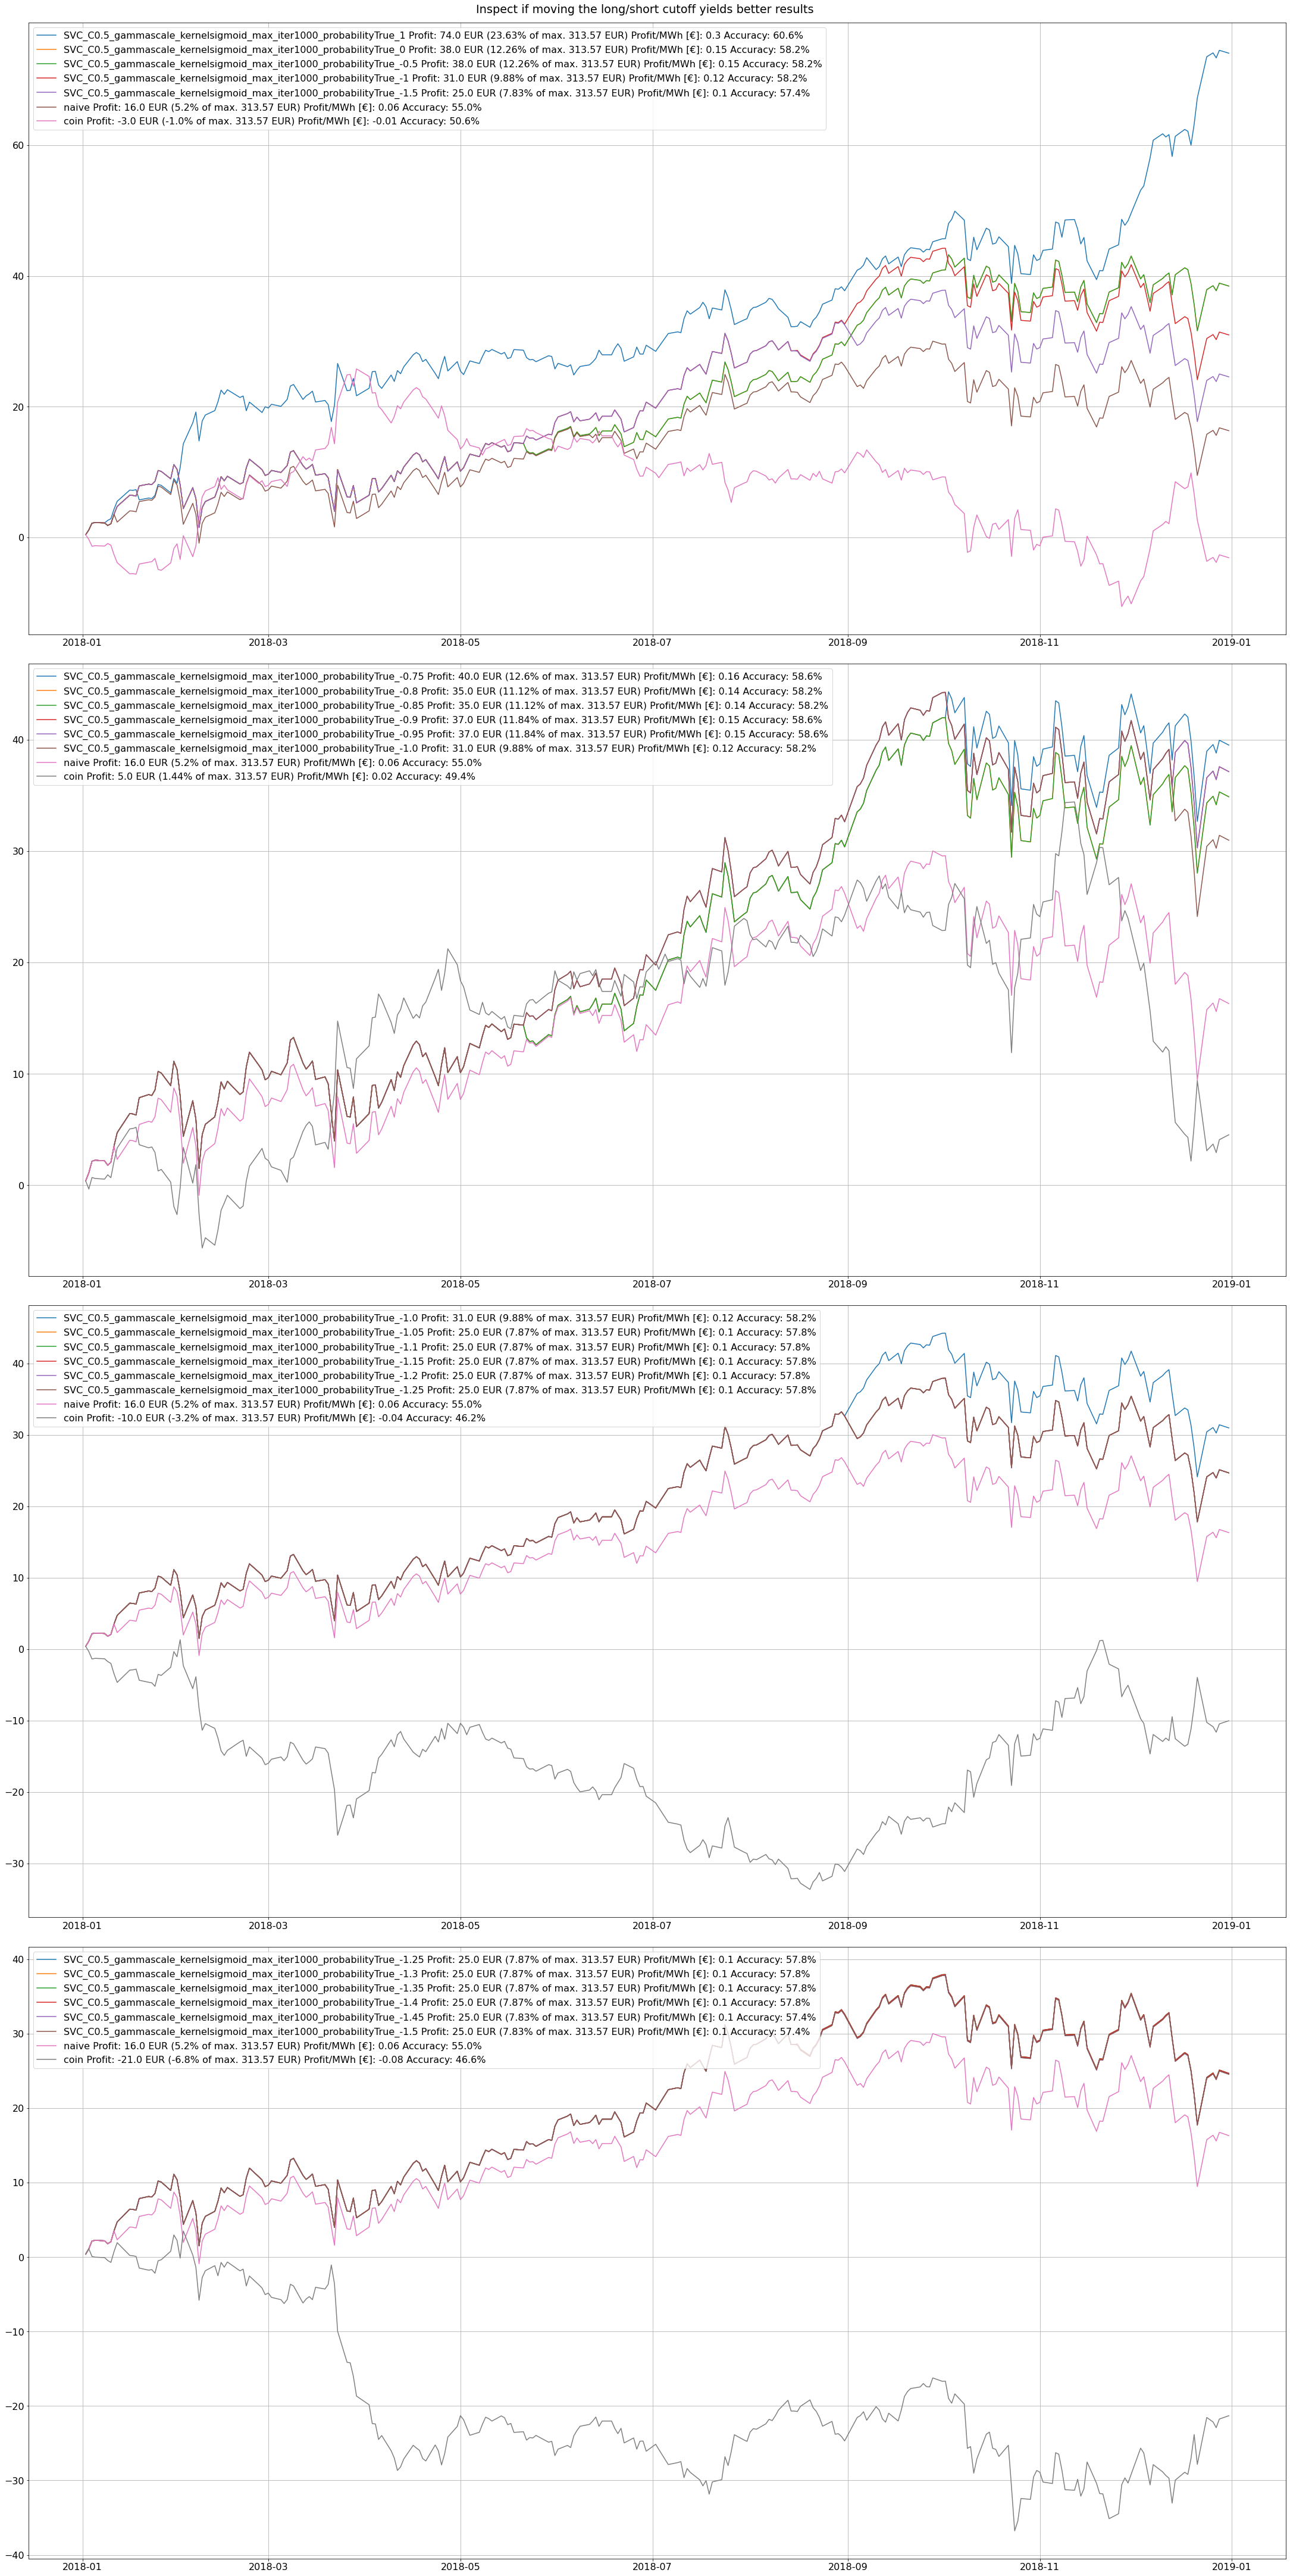

In [26]:
def plot_cutoffshift(results, model=None,dpred=None,mname=None,ax=None,steps=None,price_open=c['price_open'],
    price_close=c['price_close'],naive_sign=1):
    
    results= results.drop(columns=results.filter(regex='xgb|naive|coin').columns)
    
    # Generic Benchmarks
    results['naive_sign'] = naive_sign
    results['coin_sign'] = np.random.choice([1,-1],results.shape[0])

    
    for f in steps:
        cutoff = 0.5 + f * 0.01
        m = mname+'_'+str(f)
        results[m+'_results'] =  model.predict_proba(dpred)[:,1]
        results[m+'_sign'] = 0
        
        results.loc[results[m+'_results'] <= cutoff,m+'_sign'] = -1
        results.loc[results[m+'_results'] >= cutoff,m+'_sign'] = 1
        results[m+"_profit"] = (results[price_close]-results[price_open])*(results[m+'_sign'])  
        results[m+"_profit_cum"] = results[m+"_profit"].cumsum()

    for var in ['naive','coin']:
        results[var+"_profit"] = (results[price_close]-results[price_open])*(results[var+'_sign'])  
        results[var+"_profit_cum"] = results[var+"_profit"].cumsum()        
    
    # Plot cum. results
    for m in [mname+'_'+str(s) for s in steps]+['naive','coin']:
        profvar=m+'_profit'
        signvar=m+'_sign'
        txt_profitabs = np.round(results[profvar].sum())
        txt_profitpct = round(100*results[profvar].sum()/abs(results[price_open]-results[price_close]).sum(),2)
        txt_profitmax = round(abs(results[price_open]-results[price_close]).sum(),2)
        txt_profitmwh = round(results[profvar].sum()/results[signvar].abs().sum(),2)
        f_trade = results[signvar] != 0
        f_correct = results[signvar]==np.sign(results.spread_sign)
        txt_corspread = round(100*len(results.loc[f_trade & f_correct])/len(results.loc[(f_trade)]),1)
        text = "{} Profit: {} EUR ({}% of max. {} EUR) Profit/MWh [€]: {} Accuracy: {}%".format(
        m,
        txt_profitabs,
        txt_profitpct,
        txt_profitmax,
        txt_profitmwh,txt_corspread)
        
        
        ax.plot(results.index,results[m+'_profit_cum'], label = text)
    # Show Grid and Legend
    plt.grid() 
    plt.legend(loc=2)
 
   
import numpy as np
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = [30, 60]
plt.rcParams['font.size'] = 16
#key = 'logReg_saga_ela'

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 2)

ax0 = fig.add_subplot(gs[0, :])

plot_cutoffshift(valiset, model=cl_models[key][0],mname=key,ax=ax0,dpred=cl_models[key][2],steps=[1,0,-0.5,-1,-1.5])

ax1 = fig.add_subplot(gs[1, :])
plot_cutoffshift(valiset, model=cl_models[key][0],mname=key,ax=ax1,dpred=cl_models[key][2],steps=np.linspace(-0.75,-1,6))

ax2 = fig.add_subplot(gs[2, :])
plot_cutoffshift(valiset, model=cl_models[key][0],mname=key,ax=ax2,dpred=cl_models[key][2],steps=np.linspace(-1,-1.25,6))

ax3 = fig.add_subplot(gs[3, :])
plot_cutoffshift(valiset, model=cl_models[key][0],mname=key,ax=ax3,dpred=cl_models[key][2],steps=np.linspace(-1.25,-1.5,6))

fig.suptitle("Inspect if moving the long/short cutoff yields better results")
gs.tight_layout(fig)
gs.update(top=0.95)

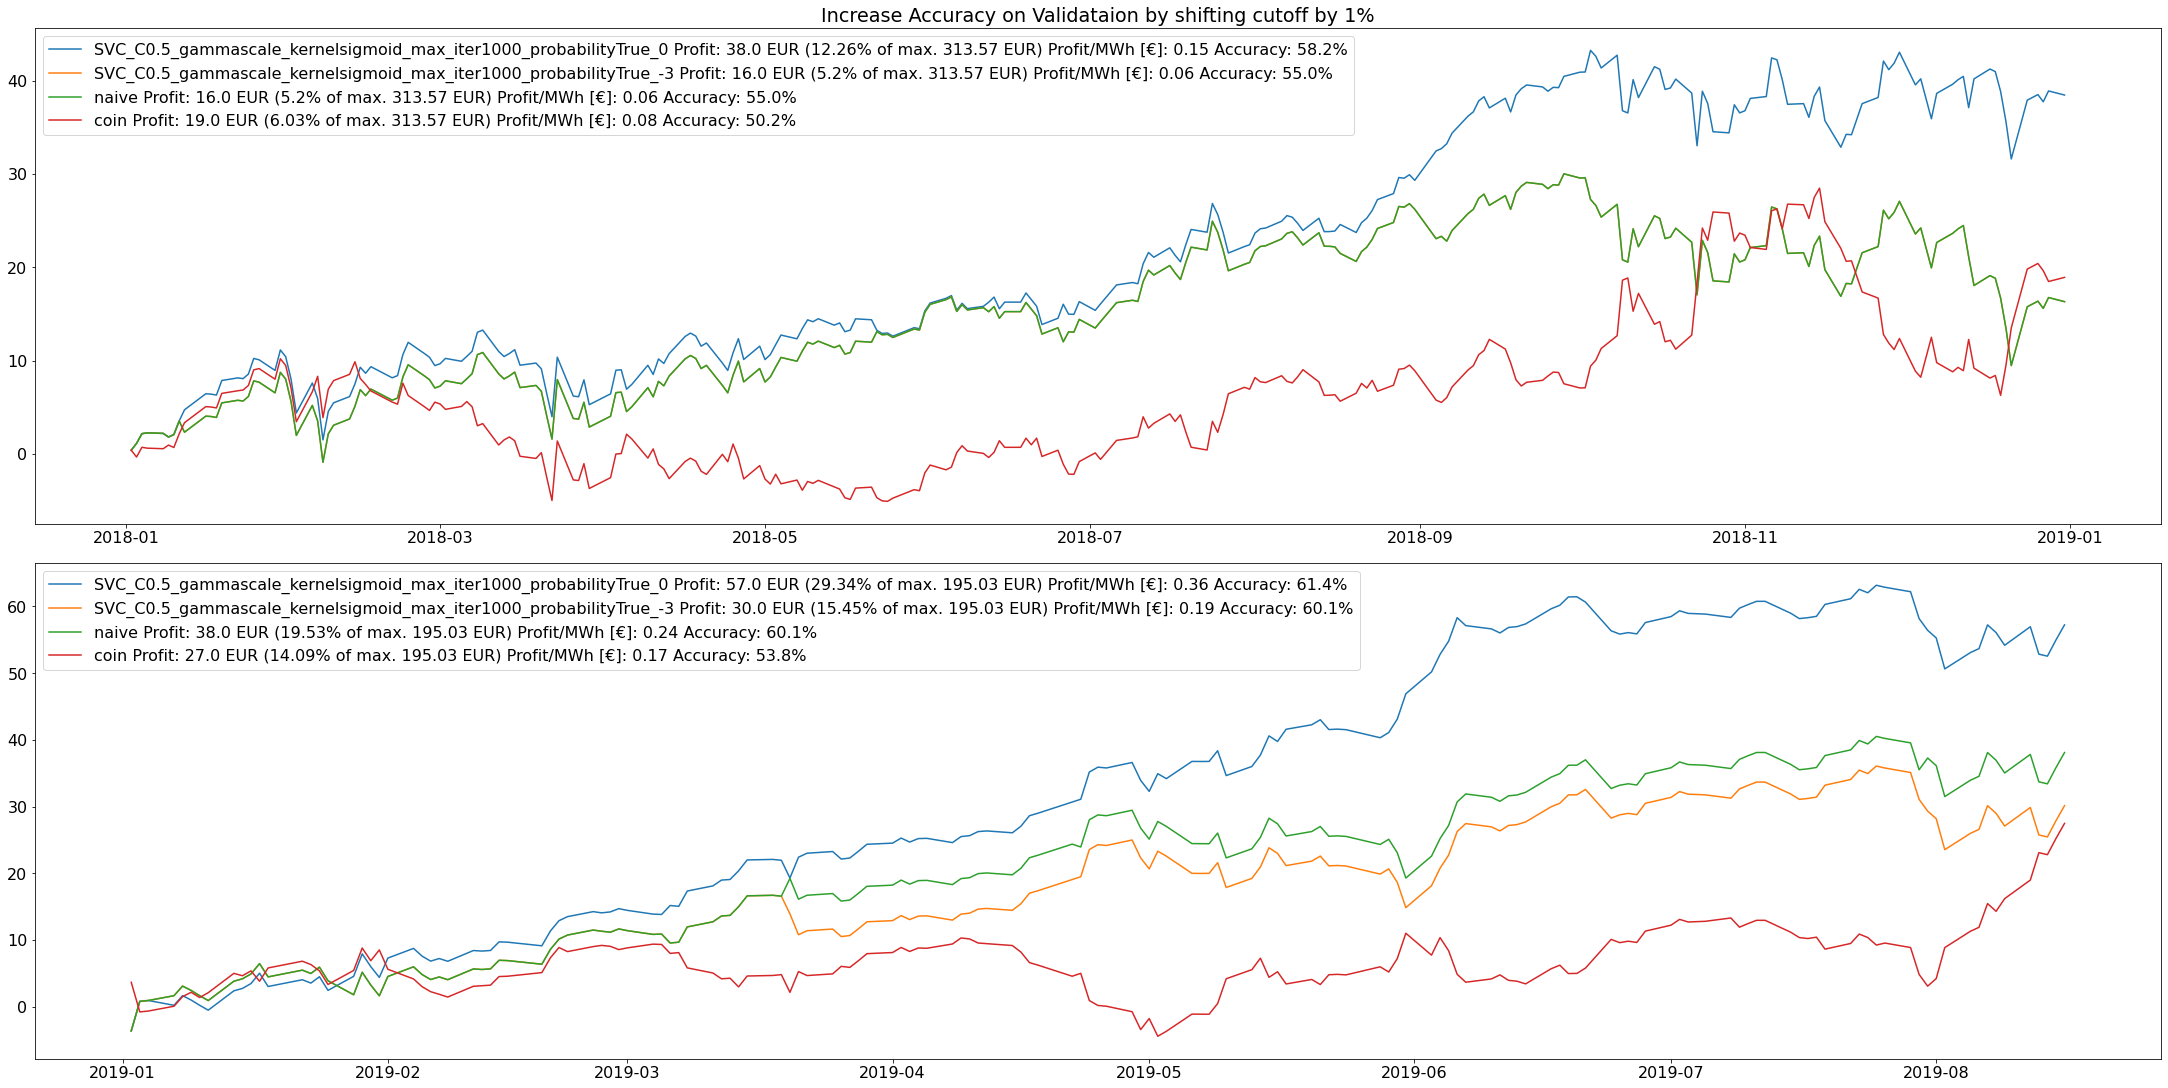

In [28]:
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams['font.size'] = 16

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
#key = 'logReg_saga_ela'
plot_cutoffshift(valiset, model=cl_models[key][0],mname=key,ax=ax0,dpred=cl_models[key][2],steps=[0,-3])
plt.grid()
plt.title("Increase Accuracy on Validataion by shifting cutoff by 1%");
ax1 = fig.add_subplot(gs[1, :])
#key = 'logReg_saga_ela'
plot_cutoffshift(testset, model=cl_models[key][0],mname=key,ax=ax1,dpred=cl_models[key][3],steps=[0,-3])
plt.grid()
